In [1]:
import numpy as np
import random
from os import listdir
from PIL import Image
import os
import glob as gb
import cv2

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_absolute_error
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tqdm import tqdm

from tensorflow.keras.applications import MobileNetV2,VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,array_to_img,img_to_array

from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

In [3]:
base_path = "archive"
files = listdir(base_path)

In [4]:
print("Total Number of Patients: "+ str(len(files)))

Total Number of Patients: 279


In [5]:
base_path = './archive/'  
dataset = []

for patient_id in os.listdir(base_path):
    for c in [0, 1]:
        patient_path = os.path.join(base_path, patient_id)
        class_path = os.path.join(patient_path, str(c))
        subfiles = os.listdir(class_path)
        
        for pic in subfiles:
            image_path = os.path.join(class_path, pic)
            dataset.append([image_path, c])


In [6]:
print("Total Number of Images: " + str(len(dataset)))

Total Number of Images: 277523


In [7]:
#How each data is stored
dataset[0]

['./archive/10253\\0\\10253_idx5_x1001_y1001_class0.png', 0]

In [8]:
total_length = len(dataset)
limit = total_length/6
dataset = dataset[:int(limit)]

len(dataset)

46253

In [9]:
image_path = dataset[0][0]
label = dataset[0][1]
image = Image.open(image_path)

# Get the size (dimensions) of the image

image_width, image_height = image.size

print(f"Image Width: {image_width} pixels")
print(f"Image Height: {image_height} pixels")

Image Width: 50 pixels
Image Height: 50 pixels


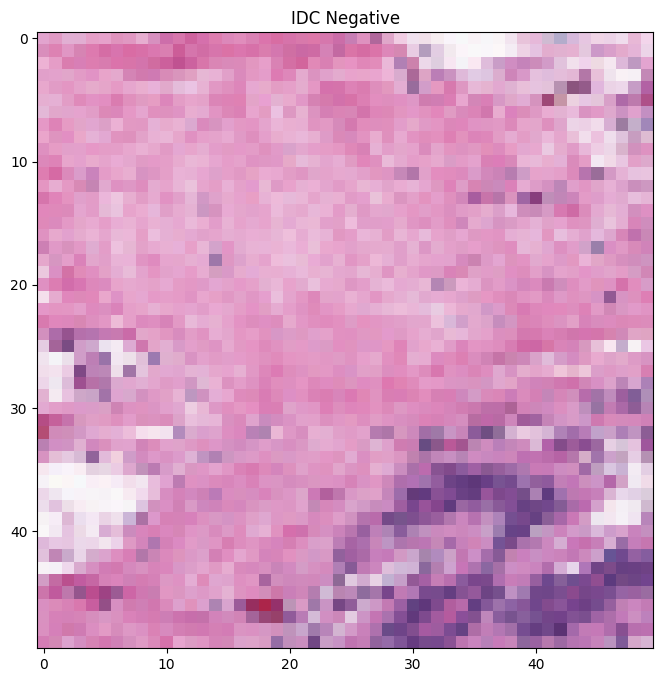

In [11]:
plt.figure(figsize=(12, 8))

plt.imshow(image)
plt.title("IDC Negative")

plt.show()

In [10]:
NCdata = [img for img, label in dataset if label == 0]
Cdata = [img for img, label in dataset if label == 1]

NClabels = [label for img, label in dataset if label == 0]
Clabels = [label for img, label in dataset if label == 1]

In [11]:
# Get a sample of images from each type of dataset
negativeSample = random.sample(NCdata, 50)
positiveSample = random.sample(Cdata, 50)

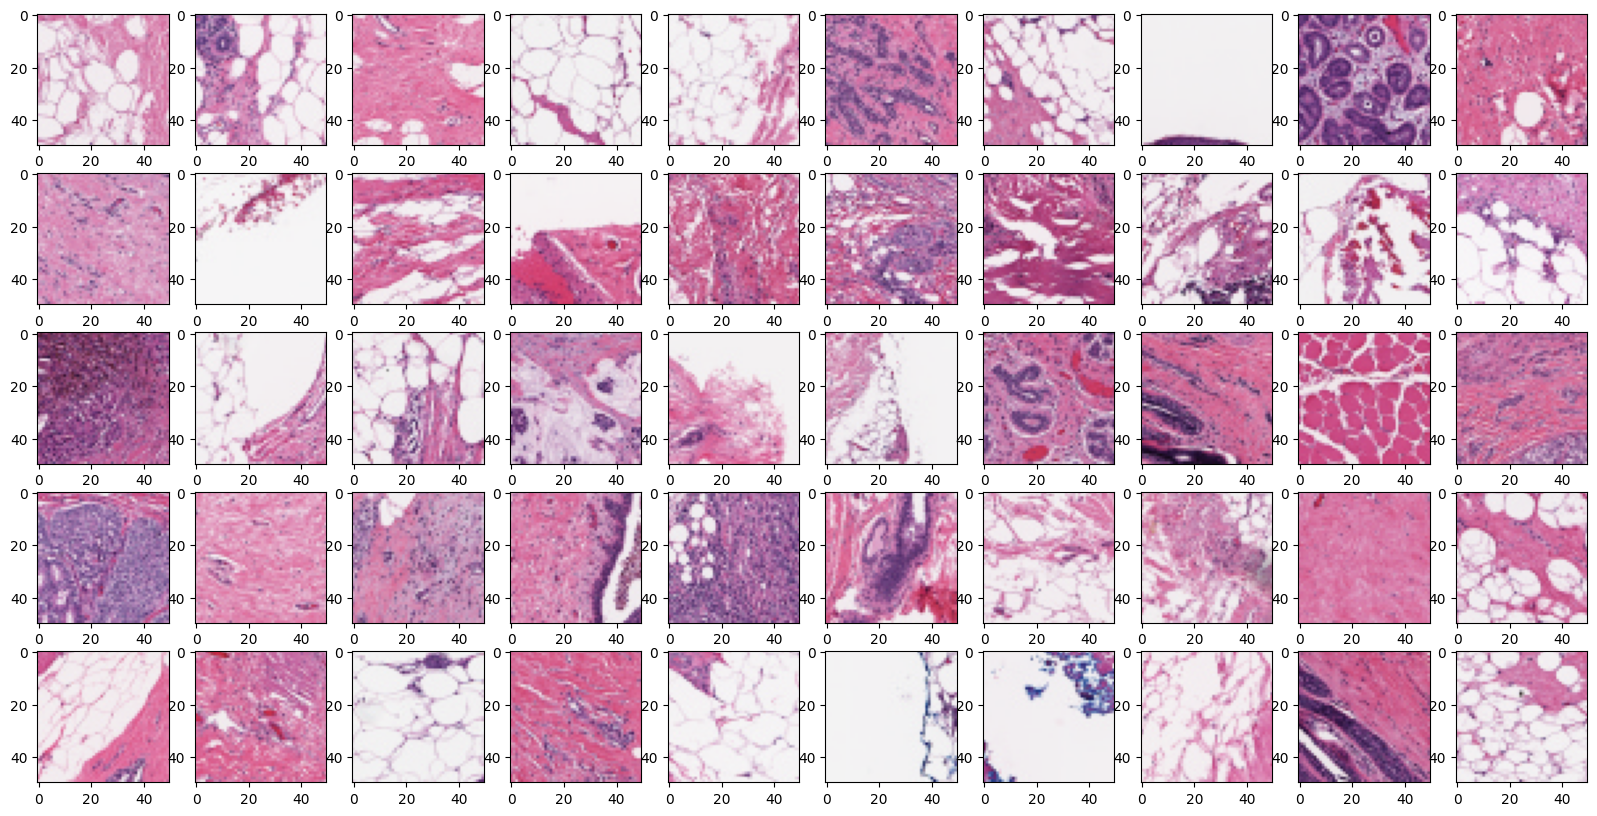

In [14]:
# Display 5x10 Grid of Healthy Patches

fig, ax = plt.subplots(5,10,figsize=(20,10))
for n in range(5):
    for m in range(10):
        idx = negativeSample[m + 10*n]
        image = Image.open(idx)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

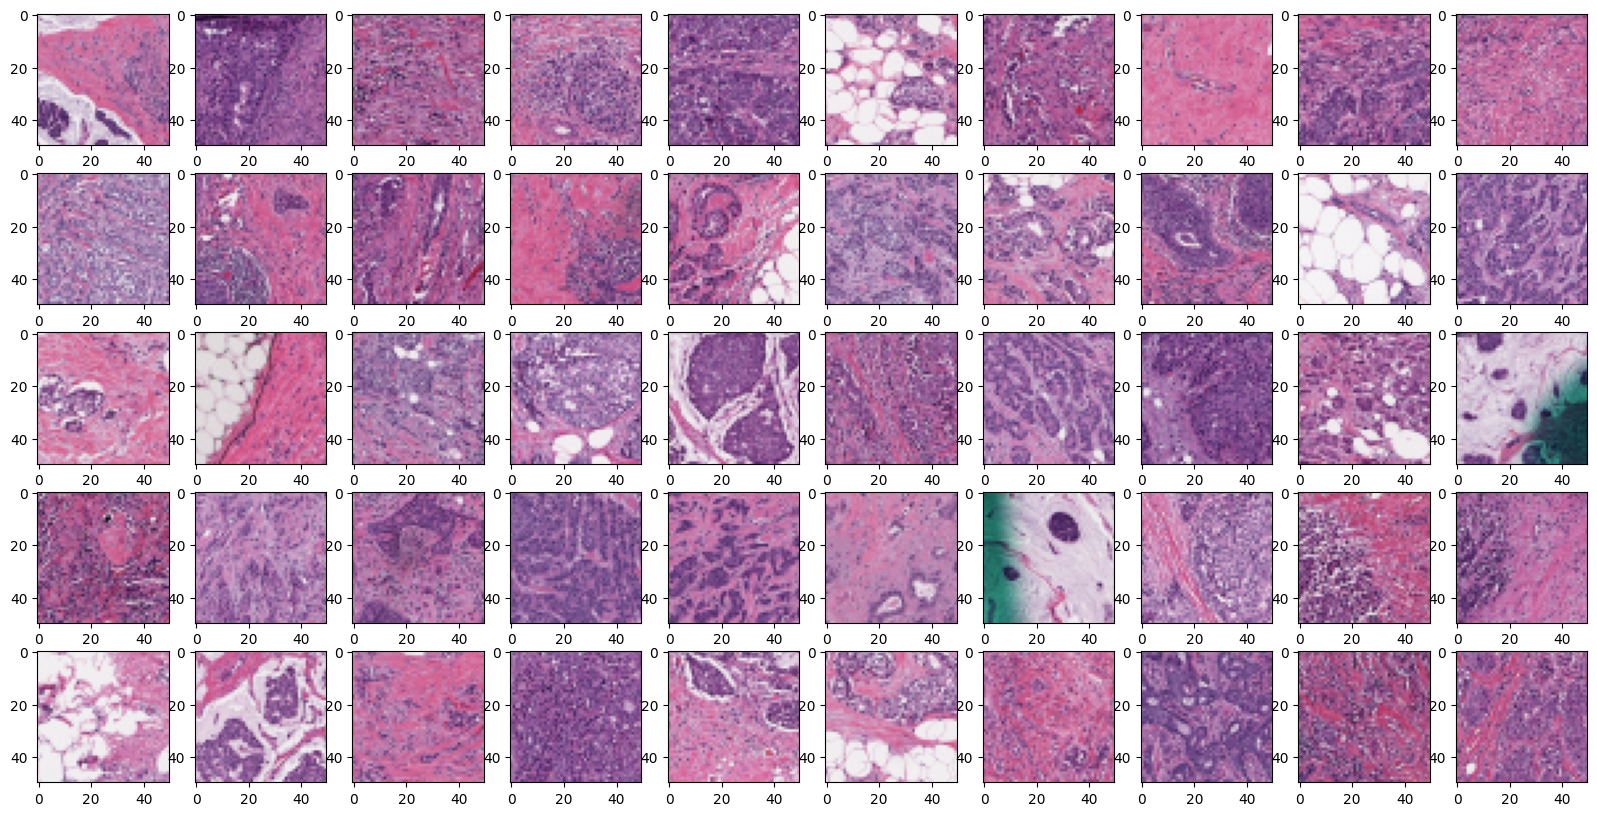

In [15]:
# Display 5x10 Grid of Cancer Patches

fig, ax = plt.subplots(5,10,figsize=(20,10))
for n in range(5):
    for m in range(10):
        idx = positiveSample[m + 10*n]
        image = Image.open(idx)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

In [12]:
# Get the class distribution

labels = ["Non-Cancer", "Cancer"]
counts = [len(NCdata), len(Cdata)]

total_samples = sum(counts)
percentages = [(count / total_samples) * 100 for count in counts]

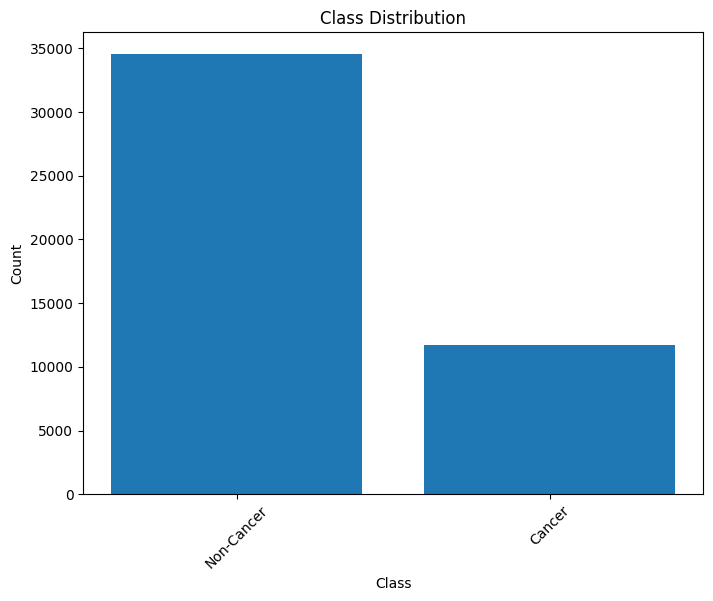

In [13]:
plt.figure(figsize=(8, 6))
plt.bar(labels, counts)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()

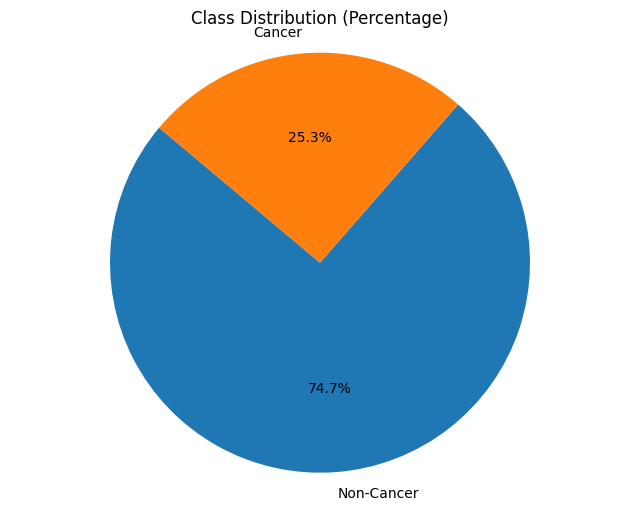

In [14]:
plt.figure(figsize=(8, 6))
plt.pie(percentages, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Class Distribution (Percentage)")
plt.axis('equal')
plt.show()

In [15]:
# Resizing using PIL Image

desired_size = (50,50)
resizedNC = []
resizedC = []

for image_path in NCdata:
    image = Image.open(image_path)
    nimage = image.resize(desired_size, Image.LANCZOS)  
    resizedNC.append(nimage)
    
for image_path in Cdata:
    image = Image.open(image_path)
    cimage = image.resize(desired_size, Image.LANCZOS) 
    resizedC.append(cimage)

In [16]:
# Normalize the Dataset pixel values to [0, 1] range

NCdataset = np.array([np.array(image) / 255.0 for image in resizedNC])
Cdataset = np.array([np.array(image) / 255.0 for image in resizedC])

In [17]:
# Shuffle the dataset

NCdataset = shuffle(NCdataset, random_state=42)
Cdataset = shuffle(Cdataset, random_state=42)

In [18]:
# Get the Shape of all dataset

print('NCdataset shape : {}' .format(NCdataset.shape))
print('Cdataset shape : {}' .format(Cdataset.shape))

NCdataset shape : (34545, 50, 50, 3)
Cdataset shape : (11708, 50, 50, 3)


In [19]:
# Split the data

# Split each dataset into training data and temporary data - 70:30

NCtrain, NCtemp, NCtrain_labels, NCtemp_labels = train_test_split(
    NCdataset, NClabels, test_size=0.3, stratify=NClabels, random_state=42
)

# Split the Cancer data
Ctrain, Ctemp, Ctrain_labels, Ctemp_labels = train_test_split(
    Cdataset, Clabels, test_size=0.3, stratify=Clabels, random_state=42
)

# Use the temporary data to split into Validation and Testing Data - 15:15
NCval, NCtest, NCval_labels, NCtest_labels = train_test_split(
    NCtemp, NCtemp_labels, test_size=0.5, stratify=NCtemp_labels, random_state=42
)

Cval, Ctest, Cval_labels, Ctest_labels = train_test_split(
    Ctemp, Ctemp_labels, test_size=0.5, stratify=Ctemp_labels, random_state=42
)

# Combine the two Non-Cancer Data and the Cancer Data to make one train_data, val_data, test_data
train_data = np.concatenate((NCtrain, Ctrain), axis=0)
train_labels = np.concatenate((NCtrain_labels, Ctrain_labels), axis=0)
val_data = np.concatenate((NCval, Cval), axis=0)
val_labels = np.concatenate((NCval_labels, Cval_labels), axis=0)
test_data = np.concatenate((NCtest, Ctest), axis=0)
test_labels = np.concatenate((NCtest_labels, Ctest_labels), axis=0)

In [20]:
# Reformat the shape for the labels

train_labels = to_categorical(train_labels, 2)
val_labels = to_categorical(val_labels, 2)
test_labels = to_categorical(test_labels, 2)

In [21]:
print('train_data shape : {}' .format(train_data.shape))
print('train_labels shape : {}' .format(train_labels.shape))
print('val_data shape : {}' .format(val_data.shape))
print('val_labels shape : {}' .format(val_labels.shape))
print('test_data shape : {}' .format(test_data.shape))
print('test_labels shape : {}' .format(test_labels.shape))

train_data shape : (32376, 50, 50, 3)
train_labels shape : (32376, 2)
val_data shape : (6938, 50, 50, 3)
val_labels shape : (6938, 2)
test_data shape : (6939, 50, 50, 3)
test_labels shape : (6939, 2)


In [22]:
model = tf.keras.Sequential([
    # Convolutional Layers
    tf.keras.layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (50, 50, 3)),
    tf.keras.layers.MaxPooling2D(strides = 2),
    tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D((3, 3),strides = 2),
    tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D((3, 3),strides =2),
    tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D((3, 3),strides =2),
    
    # Flatten Layer
    tf.keras.layers.Flatten(),
    
    # Fully Connected Layers
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(2, activation = 'softmax')
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 5, 5, 128)         0

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [25]:
history = model.fit(train_data, train_labels, validation_data = (val_data, val_labels), epochs = 25 , batch_size = 75)

Epoch 1/25


432/432 [==============================] - 37s 80ms/step - loss: 0.4030 - accuracy: 0.8219 - val_loss: 0.3542 - val_accuracy: 0.8381
Epoch 2/25
432/432 [==============================] - 33s 77ms/step - loss: 0.3542 - accuracy: 0.8451 - val_loss: 0.3354 - val_accuracy: 0.8515
Epoch 3/25
432/432 [==============================] - 34s 79ms/step - loss: 0.3382 - accuracy: 0.8520 - val_loss: 0.3240 - val_accuracy: 0.8559
Epoch 4/25
432/432 [==============================] - 34s 80ms/step - loss: 0.3298 - accuracy: 0.8588 - val_loss: 0.3420 - val_accuracy: 0.8487
Epoch 5/25
432/432 [==============================] - 34s 80ms/step - loss: 0.3278 - accuracy: 0.8586 - val_loss: 0.3242 - val_accuracy: 0.8592
Epoch 6/25
432/432 [==============================] - 34s 79ms/step - loss: 0.3182 - accuracy: 0.8634 - val_loss: 0.3105 - val_accuracy: 0.8652
Epoch 7/25
432/432 [==============================] - 34s 79ms/step - loss: 0.3082 - accuracy: 0.8677 - val_loss: 0.3110 - val_accurac

In [26]:
model.evaluate(test_data,test_labels)

217/217 [==============================] - 5s 23ms/step - loss: 0.5920 - accuracy: 0.8543


[0.5919877290725708, 0.8543017506599426]

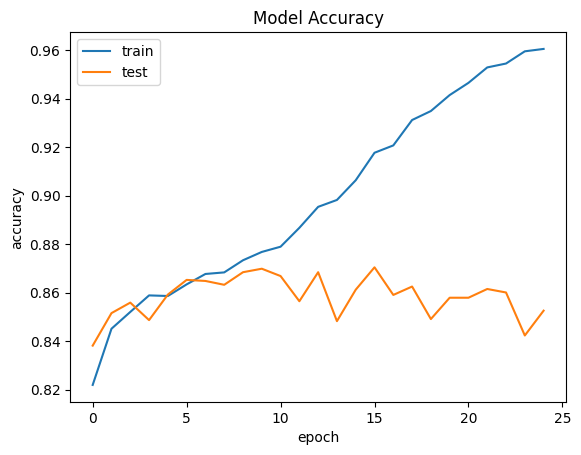

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

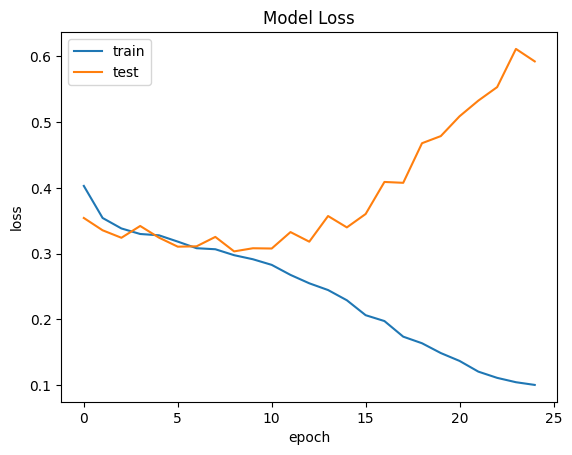

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
predict_data = model.predict(test_data)
predict_labels = np.argmax(predict_data, axis=1)

217/217 [==============================] - 5s 22ms/step


In [30]:
def convert_to_single_label(one_hot_labels):
    return np.argmax(one_hot_labels, axis=1)

# Convert train_labels
true_train_labels = convert_to_single_label(train_labels)

# Convert val_labels
true_val_labels = convert_to_single_label(val_labels)

# Convert test_labels
true_test_labels = convert_to_single_label(test_labels)

Accuracy: 0.85
Precision: 0.73
Recall: 0.66
F1-score: 0.70


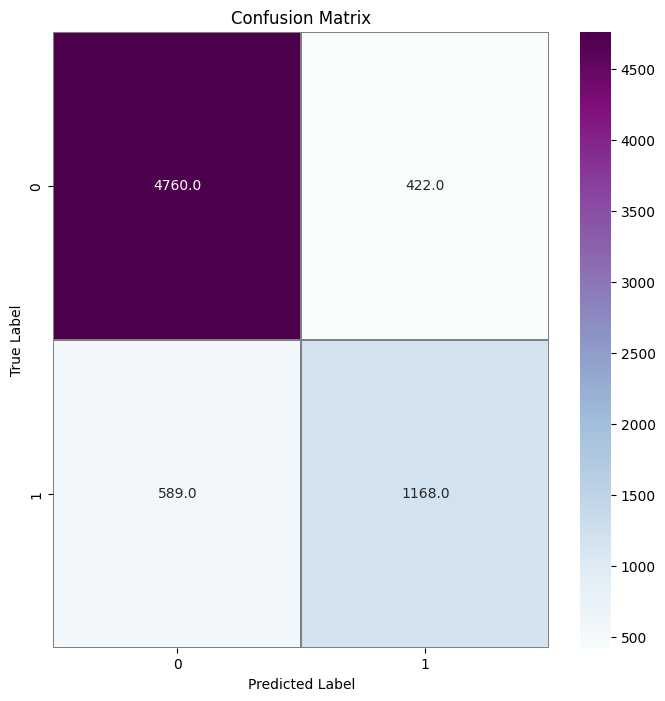

In [31]:
# Calculate accuracy
accuracy = accuracy_score(true_test_labels, predict_labels)
print(f'Accuracy: {accuracy:.2f}')

# Calculate precision
precision = precision_score(true_test_labels, predict_labels)
print(f'Precision: {precision:.2f}')

# Calculate recall
recall = recall_score(true_test_labels, predict_labels)
print(f'Recall: {recall:.2f}')

# Calculate F1-score
f1 = f1_score(true_test_labels, predict_labels)
print(f'F1-score: {f1:.2f}')

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_test_labels, predict_labels)
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [32]:
model2 = keras.Sequential([
    # Convolutional Layers
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(50, 50, 3)),
    layers.MaxPooling2D(strides=2),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((3, 3), strides=2),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((3, 3), strides=2),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((3, 3), strides=2),
    
    # Flatten Layer
    layers.Flatten(),
    
    # Fully Connected Layers
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')
])

In [33]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 50, 50, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 25, 25, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 5, 5, 128)        

In [34]:
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [35]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    patience=5,           # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True  # Restore model weights to the best epoch
)

In [36]:
history2 = model2.fit(train_data, train_labels, validation_data = (val_data, val_labels), epochs = 25 , 
                      batch_size = 256, callbacks=[early_stopping])

Epoch 1/25
127/127 [==============================] - 37s 281ms/step - loss: 0.4525 - accuracy: 0.7937 - val_loss: 0.3681 - val_accuracy: 0.8337
Epoch 2/25
127/127 [==============================] - 35s 276ms/step - loss: 0.3572 - accuracy: 0.8444 - val_loss: 0.3513 - val_accuracy: 0.8383
Epoch 3/25
127/127 [==============================] - 35s 274ms/step - loss: 0.3399 - accuracy: 0.8524 - val_loss: 0.3539 - val_accuracy: 0.8409
Epoch 4/25
127/127 [==============================] - 35s 275ms/step - loss: 0.3371 - accuracy: 0.8545 - val_loss: 0.3737 - val_accuracy: 0.8376
Epoch 5/25
127/127 [==============================] - 35s 279ms/step - loss: 0.3282 - accuracy: 0.8597 - val_loss: 0.3262 - val_accuracy: 0.8577
Epoch 6/25
127/127 [==============================] - 35s 279ms/step - loss: 0.3216 - accuracy: 0.8626 - val_loss: 0.3144 - val_accuracy: 0.8605
Epoch 7/25
127/127 [==============================] - 35s 278ms/step - loss: 0.3142 - accuracy: 0.8663 - val_loss: 0.3118 - val_ac

In [37]:
model2.evaluate(test_data,test_labels)

217/217 [==============================] - 5s 21ms/step - loss: 0.3025 - accuracy: 0.8677


[0.3025414049625397, 0.8677042722702026]

In [42]:
model.save('model_1.h5')

C:\Users\Sri Lakshmi\anaconda\envs\Srilakshmi\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


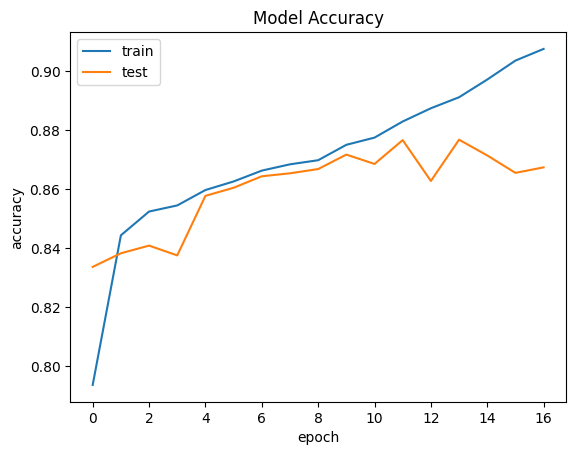

In [38]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

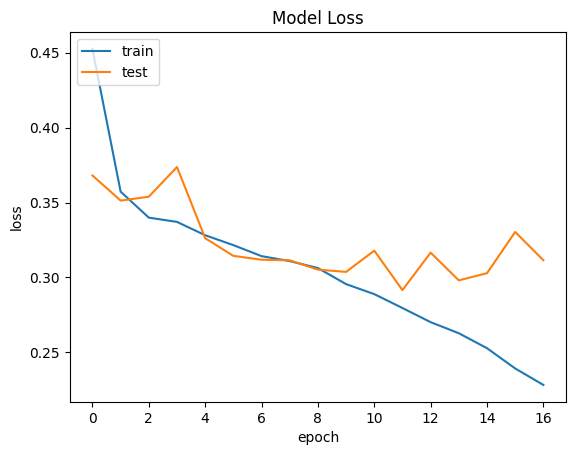

In [39]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
predict_data = model2.predict(test_data)
predict_labels = np.argmax(predict_data, axis=1)

217/217 [==============================] - 6s 26ms/step


Accuracy: 0.87
Precision: 0.76
Recall: 0.70
F1-score: 0.73


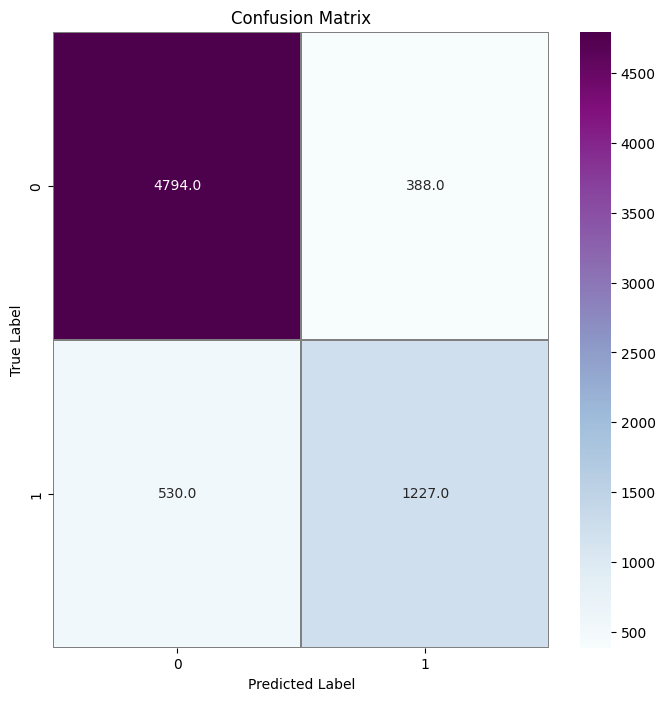

In [41]:
# Calculate accuracy
accuracy = accuracy_score(true_test_labels, predict_labels)
print(f'Accuracy: {accuracy:.2f}')

# Calculate precision
precision = precision_score(true_test_labels, predict_labels)
print(f'Precision: {precision:.2f}')

# Calculate recall
recall = recall_score(true_test_labels, predict_labels)
print(f'Recall: {recall:.2f}')

# Calculate F1-score
f1 = f1_score(true_test_labels, predict_labels)
print(f'F1-score: {f1:.2f}')

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_test_labels, predict_labels)
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [57]:
model.save('model2.h5')

C:\Users\Sri Lakshmi\anaconda\envs\Srilakshmi\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
model_cnn = load_model('model2.h5')

In [50]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# Load and preprocess the new image
img_path = './new/9383_idx5_x101_y751_class0.png'
img = image.load_img(img_path, target_size=(50, 50))  # Adjust the target size as needed
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# prediction
predictions = model_cnn.predict(img_array)

# Assuming you have only 2 classes in your binary classification model
class_labels = ["Class 0", "Class 1"]

# Make a prediction
predictions = model_cnn.predict(img_array)

# Get the predicted class and probability
predicted_class = np.argmax(predictions)
predicted_probability = predictions[0, predicted_class]

# Print the result
print(f"Predicted Class: {class_labels[predicted_class]}")
print(f"Probability: {predicted_probability}")


1/1 [==============================] - 0s 43ms/step
Predicted Class: Class 0
Probability: 1.0


In [51]:
model2_cnn = load_model('model2.h5')

In [47]:
Cdataset.shape

(11708, 50, 50, 3)

In [53]:
positive_sample = random.sample(Cdata,20)

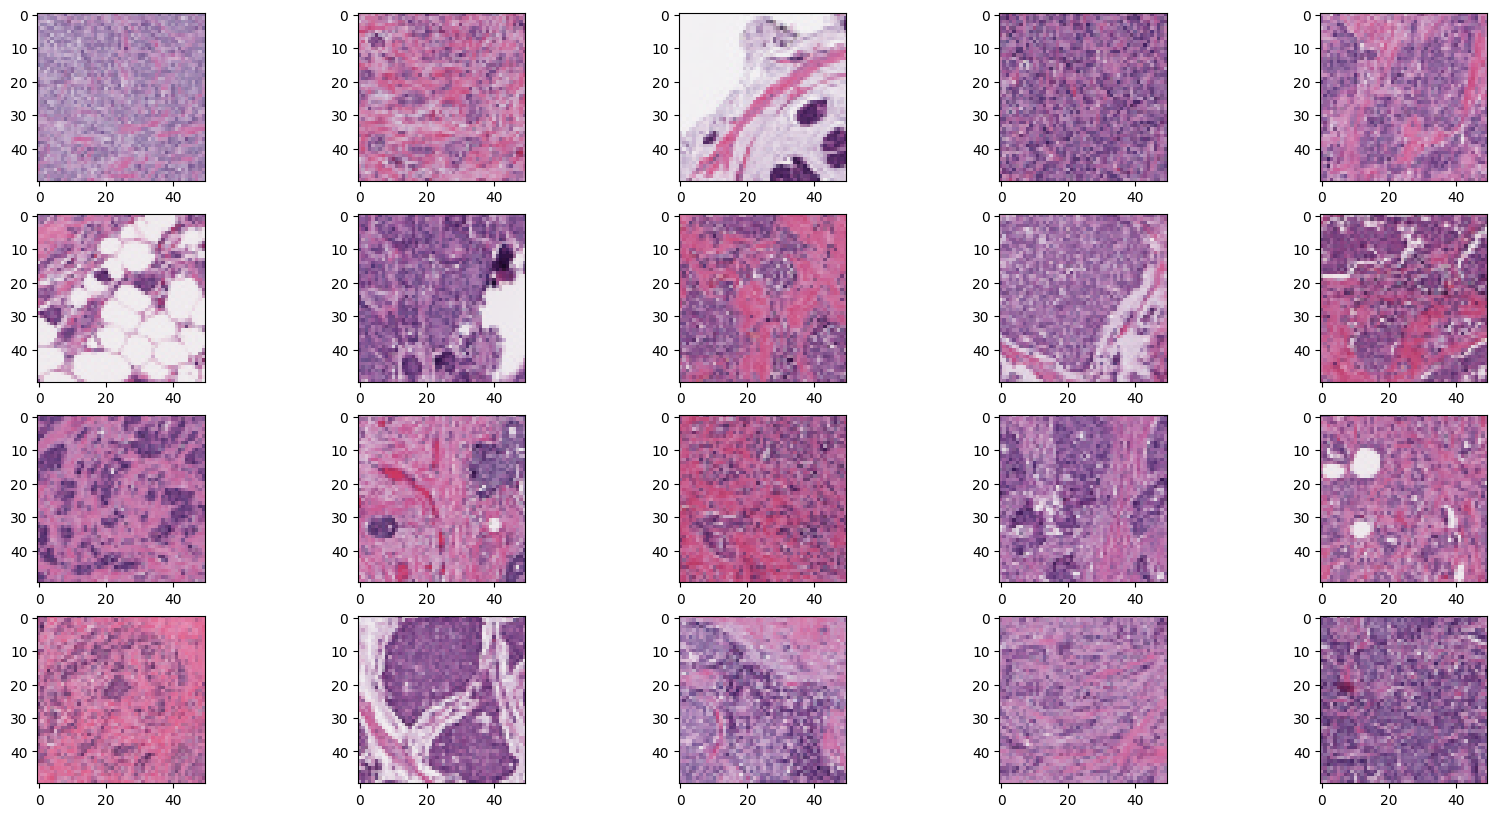

In [54]:
fig, ax = plt.subplots(4,5,figsize=(20,10))
for n in range(4):
    for m in range(5):
        idx = positive_sample[m + 5*n]
        image = Image.open(idx)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

In [79]:
image_c = cv2.imread('./new/9345_idx5_x2001_y751_class1.png')
image_c = cv2.resize(image, (50, 50))
average_color_c = np.mean(image, axis=(0, 1))

# to obtain RGB ratios
rgb_ratios_c = average_color_c / 255.0

print("For Cancerous:")
print("Average Color (BGR):", average_olor_c)
print("RGB Ratios:", rgb_ratios_c)

For Cancerous:
Average Color (BGR): [169.7552 130.784  187.0252]
RGB Ratios: [0.66570667 0.51287843 0.73343216]


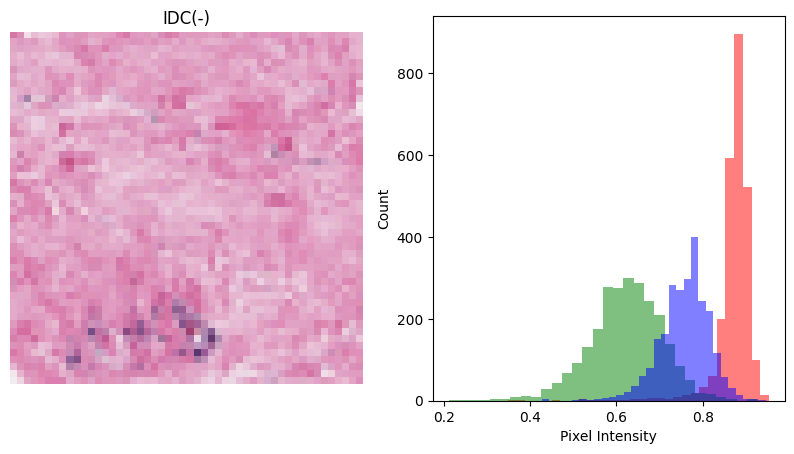

In [117]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    if label == 1:
        plt.title('IDC(+)')
    else:
        plt.title('IDC(-)')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(NCdataset[10000])

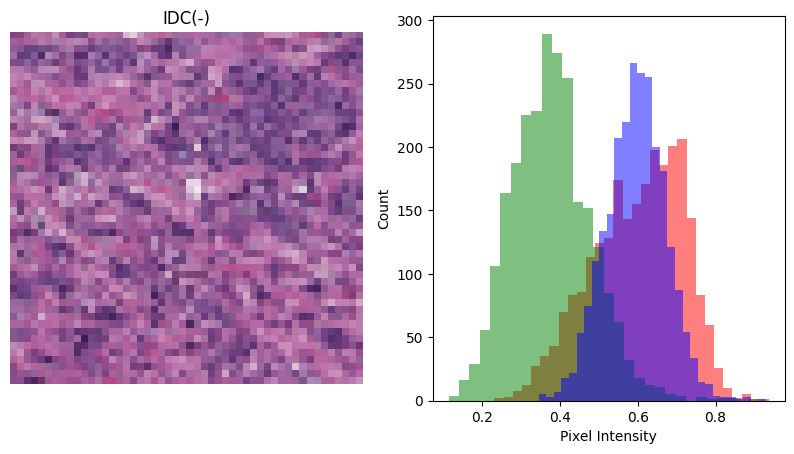

In [103]:
plotHistogram(Cdataset[100])

In [48]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from itertools import cycle

# Function to extract features from an image
def extract_features(image):
    # Ensure the image is of data type uint8
    image = (image * 255).astype(np.uint8)
    
    # Resize the image to 50x50 pixels
    image = cv2.resize(image, (50, 50))
    
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Extract purple intensity using the blue channel
    purple_intensity = image[:,:,0]
    
    # Flatten the features into a 1D array
    features = np.concatenate((gray_image.flatten(), purple_intensity.flatten()))
    return features

# Labels for each class
labels = ['In-Situ', 'idc 1', 'idc 2', 'idc 3', 'idc 4']

# Repeat labels until you reach the length of Cdataset
y = np.tile(labels, Cdataset.shape[0] // len(labels) + 1)[:Cdataset.shape[0]]

# Extract features from all images
X = [extract_features(image) for image in Cdataset]

# Flatten the feature array
X = np.array(X)

# Reshape X to (number of samples, number of features)
X = X.reshape(X.shape[0], -1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Support Vector Machine (SVM) classifier
classifier = SVC(kernel='linear')
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.20324508966695132


In [114]:
from sklearn.linear_model import LinearRegression
# Labels for each class
labels = [0,1,2,3,4]

# Repeat labels until you reach the length of Cdataset
y = np.tile(labels, Cdataset.shape[0] // len(labels) + 1)[:Cdataset.shape[0]]

# Extract features from all images
X = np.array([extract_features(image) for image in Cdataset])

# Flatten the feature array
X = X.reshape(X.shape[0], -1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute Error:", mae)

Mean absolute Error: 1.6497409805180474


In [86]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

# Function to extract features from an image
def extract_features_cnn(image):
    # Ensure the image is of data type uint8
    image = (image * 255).astype(np.uint8)
    
    # Resize the image to 50x50 pixels
    image = cv2.resize(image, (50, 50))
    
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Extract purple intensity using the blue and red channels
    purple_intensity = 0.5 * image[:,:,0] + 0.7 * image[:,:,2]  # Adjust coefficients based on your color distribution
    
    # Stack grayscale and purple intensity as channels
    features = np.stack([gray_image, purple_intensity], axis=-1)
    return features

# Labels for each class
labels = ['In-Situ', 'idc 1', 'idc 2', 'idc 3', 'idc 4']

# Extract features from all images
X = np.array([extract_features_cnn(image) for image in Cdataset])
y = np.tile(labels, Cdataset.shape[0] // len(labels) + 1)[:Cdataset.shape[0]]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape X_train and X_test to match the expected input shape of the model
X_train = X_train.reshape(X_train.shape[0], 50, 50, 2)
X_test = X_test.reshape(X_test.shape[0], 50, 50, 2)

# Instantiate the label encoder
label_encoder = LabelEncoder()

# Fit and transform labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define the custom CNN model
model_cnn_stages = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(50, 50, 2)),  # Change input shape to (50, 50, 2)
    MaxPooling2D(strides=2),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((3, 3), strides=2),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((3, 3), strides=2),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((3, 3), strides=2),    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')  
])

# Compile the model
model_cnn_stages.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_cnn_stages.fit(X_train, y_train_encoded, epochs=25, validation_data=(X_test, y_test_encoded))

# Evaluate the accuracy
accuracy = model_cnn_stages.evaluate(X_test, y_test_encoded)[1]
print("Accuracy:", accuracy)

Epoch 1/25
293/293 [==============================] - 15s 49ms/step - loss: 2.6818 - accuracy: 0.2035 - val_loss: 1.6097 - val_accuracy: 0.1930
Epoch 2/25
293/293 [==============================] - 22s 75ms/step - loss: 1.6098 - accuracy: 0.2019 - val_loss: 1.6097 - val_accuracy: 0.1939
Epoch 3/25
293/293 [==============================] - 25s 85ms/step - loss: 1.6098 - accuracy: 0.2035 - val_loss: 1.6095 - val_accuracy: 0.2011
Epoch 4/25
293/293 [==============================] - 17s 58ms/step - loss: 1.6096 - accuracy: 0.1992 - val_loss: 1.6095 - val_accuracy: 0.1921
Epoch 5/25
293/293 [==============================] - 20s 70ms/step - loss: 1.6096 - accuracy: 0.2003 - val_loss: 1.6099 - val_accuracy: 0.1921
Epoch 6/25
293/293 [==============================] - 11s 36ms/step - loss: 1.6096 - accuracy: 0.1947 - val_loss: 1.6099 - val_accuracy: 0.1921
Epoch 7/25
293/293 [==============================] - 11s 36ms/step - loss: 1.6094 - accuracy: 0.1961 - val_loss: 1.6099 - val_accuracy:

In [85]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Train the model with data augmentation
history = model_cnn_stages.fit(datagen.flow(X_train, y_train_encoded, batch_size=32), epochs=20, validation_data=(X_test, y_test_encoded))

# Evaluate the accuracy
accuracy = model_cnn_stages.evaluate(X_test, y_test_encoded)[1]
print("Accuracy:", accuracy)

Epoch 1/20


C:\Users\Sri Lakshmi\anaconda\envs\Srilakshmi\Lib\site-packages\keras\src\preprocessing\image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (9366, 50, 50, 2) (2 channels).
  warnings.warn(


293/293 [==============================] - 15s 47ms/step - loss: 1.6096 - accuracy: 0.2000 - val_loss: 1.6101 - val_accuracy: 0.1921
Epoch 2/20
293/293 [==============================] - 14s 48ms/step - loss: 1.6096 - accuracy: 0.2024 - val_loss: 1.6099 - val_accuracy: 0.1930
Epoch 3/20
293/293 [==============================] - 14s 48ms/step - loss: 1.6096 - accuracy: 0.1984 - val_loss: 1.6100 - val_accuracy: 0.1930
Epoch 4/20
293/293 [==============================] - 14s 47ms/step - loss: 1.6098 - accuracy: 0.1984 - val_loss: 1.6102 - val_accuracy: 0.2011
Epoch 5/20
293/293 [==============================] - 14s 49ms/step - loss: 1.6097 - accuracy: 0.1937 - val_loss: 1.6100 - val_accuracy: 0.1930
Epoch 6/20
293/293 [==============================] - 14s 46ms/step - loss: 1.6096 - accuracy: 0.2022 - val_loss: 1.6099 - val_accuracy: 0.1921
Epoch 7/20
293/293 [==============================] - 15s 51ms/step - loss: 1.6096 - accuracy: 0.1966 - val_loss: 1.6098 - val_accuracy: 0.1921
Epo

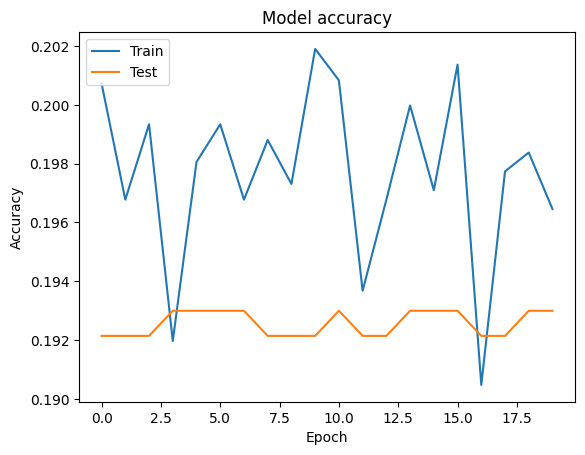

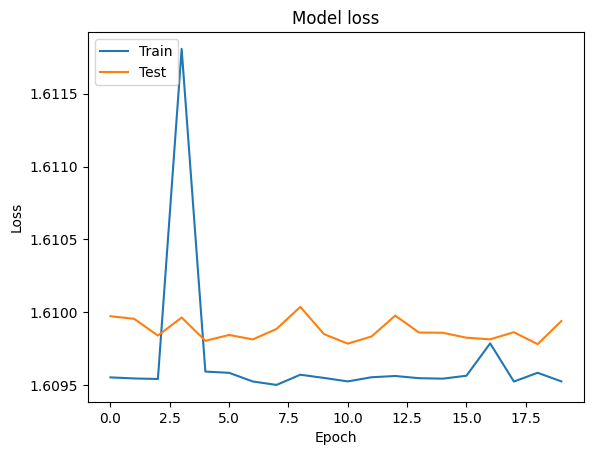

In [54]:
def plot_history(history):
    # Plot training history
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot testing history
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

plot_history(history)


In [58]:
predict_data_stages = model_cnn_stages.predict(X_test)
predict_labels_stages = np.argmax(predict_data_stages, axis=1)

74/74 [==============================] - 2s 22ms/step


74/74 [==============================] - 2s 23ms/step
Accuracy: 0.19
Class: In-Situ, Precision: 0.00, Recall: 0.00, F1-score: 0.00
Class: idc 1, Precision: 0.19, Recall: 1.00, F1-score: 0.32
Class: idc 2, Precision: 0.00, Recall: 0.00, F1-score: 0.00
Class: idc 3, Precision: 0.00, Recall: 0.00, F1-score: 0.00
Class: idc 4, Precision: 0.00, Recall: 0.00, F1-score: 0.00


C:\Users\Sri Lakshmi\anaconda\envs\Srilakshmi\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


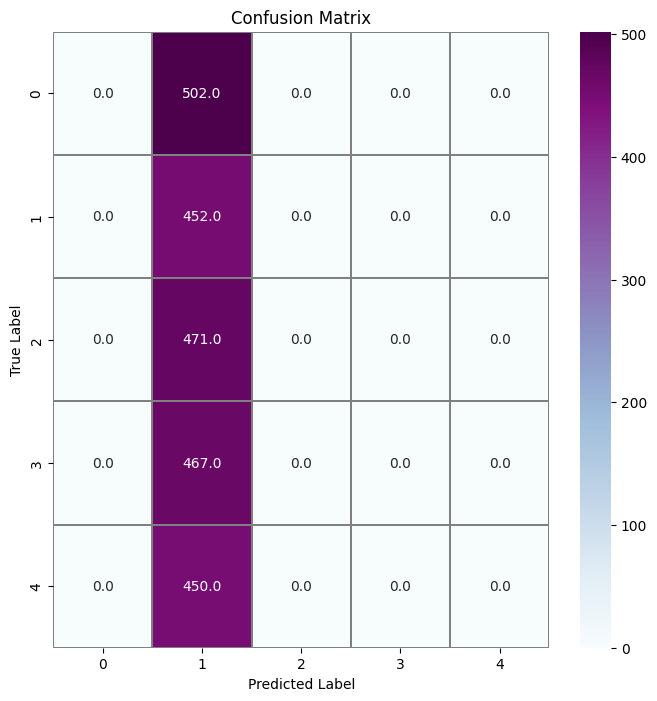

In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model_cnn_stages.predict(X_test)
predict_labels_stages = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, predict_labels_stages)
print(f'Accuracy: {accuracy:.2f}')

# Calculate precision, recall, and F1-score for each class
precision = precision_score(y_test_encoded, predict_labels_stages, average=None)
recall = recall_score(y_test_encoded, predict_labels_stages, average=None)
f1 = f1_score(y_test_encoded, predict_labels_stages, average=None)

# Print precision, recall, and F1-score for each class
for label, p, r, f in zip(labels, precision, recall, f1):
    print(f'Class: {label}, Precision: {p:.2f}, Recall: {r:.2f}, F1-score: {f:.2f}')

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, predict_labels_stages)
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


74/74 [==============================] - 2s 23ms/step


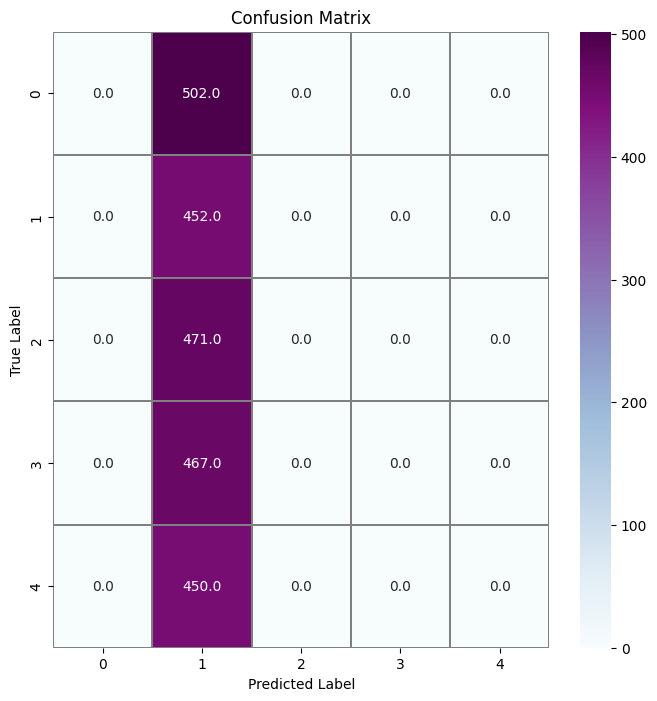

In [64]:
# Make predictions on the test set
y_pred_stages = model_cnn_stages.predict(X_test)

# Convert one-hot encoded predictions to class indices
class_indices = np.argmax(y_pred_stages, axis=1)

# Decode the class indices using label_encoder
predict_labels_stages = label_encoder.inverse_transform(class_indices)

# Calculate precision, recall, and F1-score with zero_division parameter
precision = precision_score(y_test_encoded, class_indices, average=None, zero_division=1)
recall = recall_score(y_test_encoded, class_indices, average=None, zero_division=1)
f1 = f1_score(y_test_encoded, class_indices, average=None, zero_division=1)

# Get unique labels from true labels and predicted labels
unique_labels = np.unique(np.concatenate((y_test_encoded, class_indices)))

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, class_indices, labels=unique_labels)
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

1/1 [==============================] - 0s 53ms/step
Predicted Label: idc 1


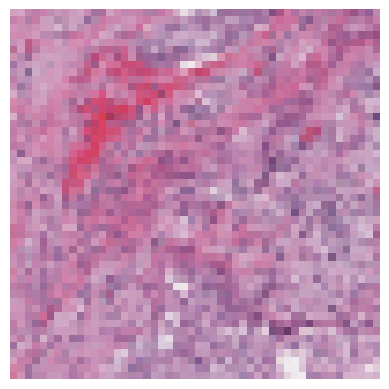

In [69]:
# Load and preprocess the image you want to predict
image_to_predict = cv2.imread('./new/9345_idx5_x2001_y751_class1.png')  
image_to_predict_features = extract_features_cnn(image_to_predict)
image_to_predict_input = image_to_predict_features.reshape(1, 50, 50, 2)

# Make the prediction
prediction = model_cnn_stages.predict(image_to_predict_input)

# Decode the prediction using label_encoder
predicted_label_index = np.argmax(prediction)
predicted_label = label_encoder.classes_[predicted_label_index]

print("Predicted Label:", predicted_label)

# Convert from BGR to RGB (matplotlib uses RGB)
image_rgb = cv2.cvtColor(image_to_predict, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.axis('off')  
plt.show()